# __<u>Initialize Cloud-AI Engine</u>__ 
> with a developed and distinct environment: __py39-VPP (Python 3.9.16)__
>> in case of env problem, you can use --> cmd Run: __conda install -n (your env) ipykernel --update-deps --force-reinstall__

> Install/Verify Packages

In [1]:
# %pip install --user --upgrade pandas
# %pip install --user --upgrade "sqlalchemy<2.0"
# %pip install --user --upgrade mariadb
# %pip install --user --upgrade -U matplotlib
# %pip install --user --upgrade seaborn
# %pip install --user -U scikit-learn
# %pip install --user --upgrade "tensorflow-gpu<2.10"
# %pip install --user --upgrade keras-rl
# %pip install --user --upgrade gym
# %pip install --user --upgrade deap
# %pip install --user --upgrade statsmodels

> Import Libraries

In [2]:
import os
import pickle
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import time
from deap import base, creator, tools, algorithms
from statsmodels.tsa.arima.model import ARIMA

# __<u>Configure Simulation Setup__

> Define Input Data Directory

In [3]:
loadDirectory = '../Data/ProcessedData/'

>Define Output Data Directory

In [4]:
saveDirectory = 'v3.1'
# create saveDirectory directory if it doesn't exist
if not os.path.exists(saveDirectory):
    os.makedirs(saveDirectory)
    print(f"System has created \"{saveDirectory}\" directory.")
else:
    print(f"The directory \"{saveDirectory}\" already exists.")

The directory "v3.1" already exists.


> Define colunmns and rows of pandas output

In [5]:
# pd.set_option('display.max_columns', 50)
# pd.set_option('display.max_rows', 50000)

# __<u>PV Data Processing for Model Development and Testing</u>__

> __<u> Load Pre-processed Power Plants data for each PV power plant </u>__
>> Note from ENS: 
>>   * Power_Plant 3, C_pcode __71780001~71780003__ : Seomyeon, Gyeongju-si, Gyeongsangbuk-do

In [6]:
PV1 = pd.read_csv(f"{loadDirectory}PV_71780001.gzip", compression="gzip")
PV2 = pd.read_csv(f"{loadDirectory}PV_71780002.gzip", compression="gzip") 
PV3 = pd.read_csv(f"{loadDirectory}PV_71780004.gzip", compression="gzip")

> <b>Dropped</b> unnecessary data, <b>renamed</b> column and <b>set index</b> with timestamp

In [7]:
PV1 = PV1.drop(columns={'day_power'}).rename(columns={'inst_power':'pv1_power'}).set_index('timestamp')
PV2 = PV2.drop(columns={'day_power'}).rename(columns={'inst_power':'pv2_power'}).set_index('timestamp')
PV3 = PV3.drop(columns={'day_power'}).rename(columns={'inst_power':'pv3_power'}).set_index('timestamp')

>Combine above dataFrames to <b>raw_data</b> according to the index and <b>calculated total power</b>

In [8]:
raw_data = PV1.join(PV2).join(PV3)
raw_data = raw_data.fillna(0)
# calculate the total power output and add it as a new column
raw_data['total_power'] = raw_data.sum(axis=1)
raw_data=raw_data.reset_index()
# Convert the 'timestamp' column to a pandas datetime object
raw_data['timestamp'] = pd.to_datetime(raw_data['timestamp'])
raw_data ['timestamp'][0]

Timestamp('2020-11-10 18:20:00')

In [9]:
raw_data

,timestamp,pv1_power,pv2_power,pv3_power,total_power
0,2020-11-10 18:20:00,0.0,0.0,0.0,0.0
1,2020-11-10 18:21:00,0.0,0.0,0.0,0.0
2,2020-11-10 18:22:00,0.0,0.0,0.0,0.0
3,2020-11-10 18:23:00,0.0,0.0,0.0,0.0
4,2020-11-10 18:24:00,0.0,0.0,0.0,0.0
...,...,...,...,...,...
1265481,2023-05-10 17:34:00,10.6,11.9,13.9,36.4
1265482,2023-05-10 17:35:00,10.6,11.8,13.2,35.6
1265483,2023-05-10 17:36:00,11.1,11.1,14.5,36.7
1265484,2023-05-10 17:37:00,10.4,10.7,14.8,35.9


> __<u> Customized Functions </u>__
>> Note for ENS: 
>>   * hourly data calculation
>>   * grid demand generator
>>   * grid power generator

In [10]:
class GridDemandGenerator:
    def __init__(self, max_demand):
        self.max_demand = max_demand
    
    def generate_daily_grid_demand(self, timestamp):
        t = timestamp.time()
        if time(22, 0) <= t or t < time(6, 0):
            return 0.25 # 25%
        elif time(6, 0) <= t < time(14, 0):
            return 0.5  # 50%
        elif time(14, 0) <= t < time(18, 0):
            return 0.75 # 75%
        elif time(18, 0) <= t < time(22, 0):
            return 1.0 # 100%
    
    def adjust_seasonal_grid_demand(self, row):
        timestamp = pd.to_datetime(row['timestamp'])
        month = timestamp.month
        grid_demand = self.max_demand * self.generate_daily_grid_demand(timestamp)
        if month in [1, 2, 12]:
            adjustment = random.uniform(0.20, 0.25)
        elif month in [6, 7, 8, 9]:
            adjustment = random.uniform(0.10, 0.20)
        elif month in [3, 4, 5]:
            adjustment = random.uniform(-0.05, 0.10)
        elif month in [10, 11]:
            adjustment = random.uniform(-0.05, 0.15)
        else:
            adjustment = 0
        adjusted_demand = grid_demand * (1 + adjustment)
        return round(adjusted_demand, 1)
    
    def get_grid_demand(self, df):
        df['timestamp']   = pd.to_datetime(df['timestamp'])
        df['grid_demand'] = df.apply(self.adjust_seasonal_grid_demand, axis=1)
        df.fillna(0, inplace=True)
        return df

In [11]:
class GridPowerGenerator:
    def __init__(self, max_generation):
        self.max_generation = max_generation
    
    def generate_daily_grid_power(self, timestamp):
        t = timestamp.time()
        if time(22, 0) <= t or t < time(6, 0):
            return 0.7 # 70%
        elif time(6, 0) <= t < time(14, 0):
            return 0.7 # 70%
        elif time(14, 0) <= t < time(18, 0):
            return 0.7 # 70%
        elif time(18, 0) <= t < time(22, 0):
            return 1.0 # 100%
    
    def adjust_seasonal_grid_power(self, row):
        timestamp = pd.to_datetime(row['timestamp'])
        month = timestamp.month
        grid_power = self.max_generation * self.generate_daily_grid_power(timestamp)
        if month in [1, 2, 12]:
            adjustment = random.uniform(-0.1, 0.1)
        elif month in [6, 7, 8, 9]:
            adjustment = random.uniform(0.2, 0.3)
        elif month in [3, 4, 5]:
            adjustment = random.uniform(-0.05, 0.05)
        elif month in [10, 11]:
            adjustment = random.uniform(0.05, 0.15)
        else:
            adjustment = 0
        adjusted_power = grid_power * (1 + adjustment)
        return round(adjusted_power, 1)
    
    def get_grid_power(self, df):
        df['timestamp']   = pd.to_datetime(df['timestamp'])
        df['grid_power'] = df.apply(self.adjust_seasonal_grid_power, axis=1)
        df.fillna(0, inplace=True)
        return df

In [12]:
def calculate_hourly_data(data):
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data.set_index('timestamp', inplace=True)
    hourly_data = data.resample('H').sum()
    hourly_data=hourly_data.reset_index()
    hourly_data['timestamp'] = pd.to_datetime(hourly_data['timestamp'])
    hourly_data.fillna(0, inplace=True) # Fill null values with zero
    return hourly_data

In [13]:
data = GridDemandGenerator(max_demand=200).get_grid_demand(raw_data)
data = GridPowerGenerator(max_generation=150).get_grid_power(data)
hourly_data = calculate_hourly_data(data)
hourly_data

,timestamp,pv1_power,pv2_power,pv3_power,total_power,grid_demand,grid_power
0,2020-11-10 18:00:00,0.0,0.0,0.0,0.0,8412.4,6569.5
1,2020-11-10 19:00:00,0.0,0.0,0.0,0.0,12618.7,9939.8
2,2020-11-10 20:00:00,0.0,0.0,0.0,0.0,12451.0,9867.7
3,2020-11-10 21:00:00,0.0,0.0,0.0,0.0,12676.1,9840.4
4,2020-11-10 22:00:00,0.0,0.0,0.0,0.0,3143.7,6998.1
...,...,...,...,...,...,...,...
20531,2023-03-16 05:00:00,0.0,0.0,0.0,0.0,3074.0,6296.7
20532,2023-03-16 06:00:00,45.0,40.9,21.8,107.7,6149.9,6320.1
20533,2023-03-16 07:00:00,437.1,416.3,357.2,1210.6,6111.6,6314.5
20534,2023-03-16 08:00:00,1287.9,1213.1,1035.1,3536.1,6194.2,6286.9


>Plot each column of <b>plot_data</b> against the timestamp

In [14]:
def plot_columns_vs_x(df):
    """
    Plot each column of a pandas DataFrame against the x-axis (dt column), where the x-axis is automatically
    detected based on the dtype of the column. Columns with non-numeric dtypes are ignored.
    
    Parameters:
    df (pandas DataFrame): The DataFrame to plot.
    """
    # Find the column with the datetime data and set it as the x-axis
    for col_name in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[col_name]):
            x_values = df[col_name]
            x_label = col_name
            break
    else:
        print("No datetime column found. Unable to plot.")
        return

    # Make a copy of the DataFrame with the datetime column removed
    numeric_cols = [col_name for col_name in df.columns if pd.api.types.is_numeric_dtype(df[col_name])]
    df_numeric = df[numeric_cols]
        
    # Plot each column against the x-axis
    num_cols = len(df_numeric.columns)
    fig, axs = plt.subplots(num_cols, 1, figsize=(18, 6), sharex=True)
    fig.set_facecolor(color = 'antiquewhite')
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams['font.size'] = '9'
    for i, col_name in enumerate(df_numeric.columns):
        axs[i].plot(x_values, df_numeric[col_name], label=col_name, color = 'gray')
        if '_w' in col_name:
            axs[i].set_ylabel('Watt', color='chocolate')
        elif '_c' in col_name:
            axs[i].set_ylabel('DegC', color='chocolate')
        elif '_%' in col_name:
            axs[i].set_ylabel('g/m^3', color='chocolate')
        elif 'power' in col_name:
            axs[i].set_ylabel('kWh', color='chocolate')
        elif 'grid_demand' in col_name:
            axs[i].set_ylabel('kWh', color='chocolate')
        else:
            axs[i].set_ylabel('Unknown', color='chocolate')
        axs[0].set_title(f'Graphical Representation of {numeric_cols} data', color='brown')
        axs[i].legend(loc="upper right")
        axs[i].grid(True, linestyle='--', alpha=0.7, color='salmon')
    plt.xlabel('Timestamp', color='chocolate')
    plt.show()

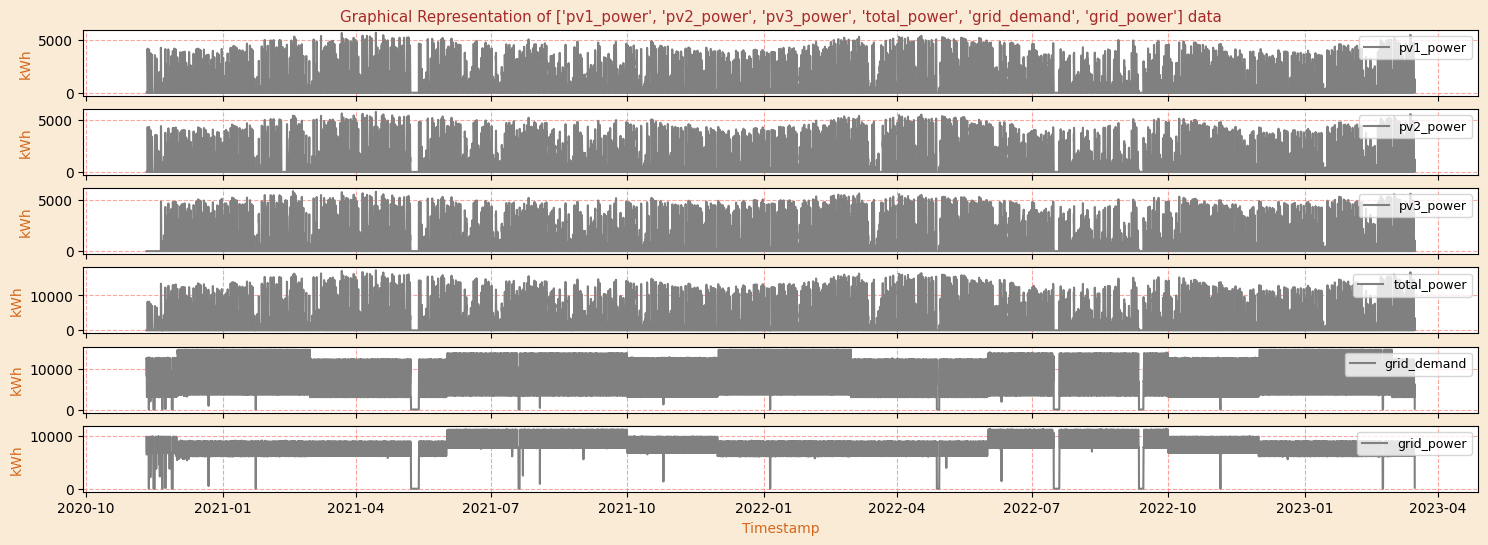

In [15]:
plot_columns_vs_x(hourly_data)

In [16]:
plot_data = hourly_data[len(hourly_data)-24*30*3:] # Last 3 month data
plot_data

,timestamp,pv1_power,pv2_power,pv3_power,total_power,grid_demand,grid_power
18376,2022-12-16 10:00:00,2935.8,2464.9,3464.2,8864.9,7385.0,6282.0
18377,2022-12-16 11:00:00,2444.8,2700.2,2773.1,7918.1,7345.4,6361.7
18378,2022-12-16 12:00:00,2514.9,2867.0,3346.0,8727.9,7337.6,6262.1
18379,2022-12-16 13:00:00,1771.3,1947.3,2517.9,6236.5,7335.4,6352.1
18380,2022-12-16 14:00:00,1233.6,1322.5,1804.0,4360.1,11036.1,6362.6
...,...,...,...,...,...,...,...
20531,2023-03-16 05:00:00,0.0,0.0,0.0,0.0,3074.0,6296.7
20532,2023-03-16 06:00:00,45.0,40.9,21.8,107.7,6149.9,6320.1
20533,2023-03-16 07:00:00,437.1,416.3,357.2,1210.6,6111.6,6314.5
20534,2023-03-16 08:00:00,1287.9,1213.1,1035.1,3536.1,6194.2,6286.9


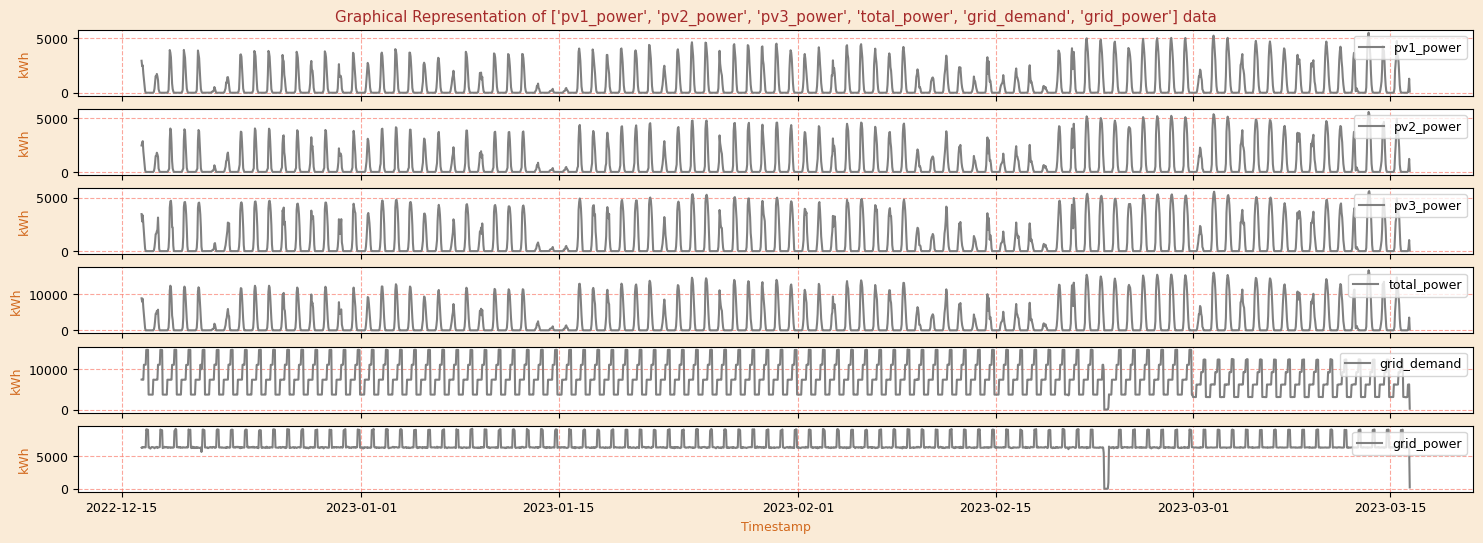

In [17]:
plot_columns_vs_x(plot_data)

> <b>Data --> NP Array</b>

In [18]:
# input features
data = plot_data.drop(columns=['timestamp'])
# Convert plot_data to data_np as np array
data_np = np.array(data)
# Replacing 0 with 0.01
# data_np[data_np == 0] = 0.01
data_np

array([[2935.8, 2464.9, 3464.2, 8864.9, 7385. , 6282. ],
       [2444.8, 2700.2, 2773.1, 7918.1, 7345.4, 6361.7],
       [2514.9, 2867. , 3346. , 8727.9, 7337.6, 6262.1],
       ...,
       [ 437.1,  416.3,  357.2, 1210.6, 6111.6, 6314.5],
       [1287.9, 1213.1, 1035.1, 3536.1, 6194.2, 6286.9],
       [ 103.9,  100.7,   56.3,  260.9,  203.7,  202.1]])

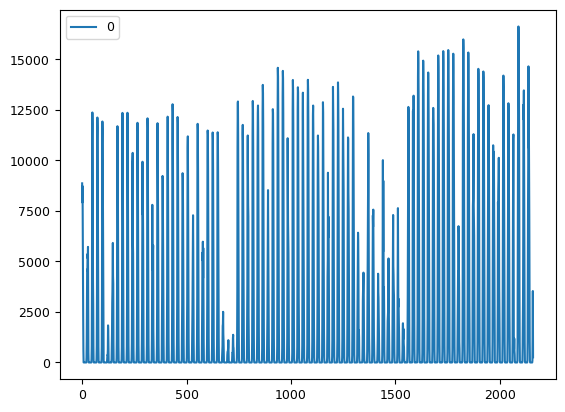

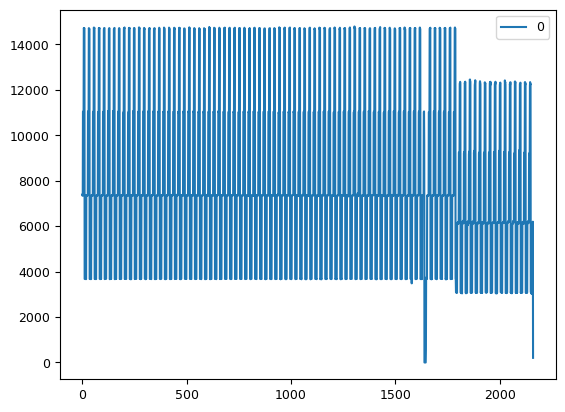

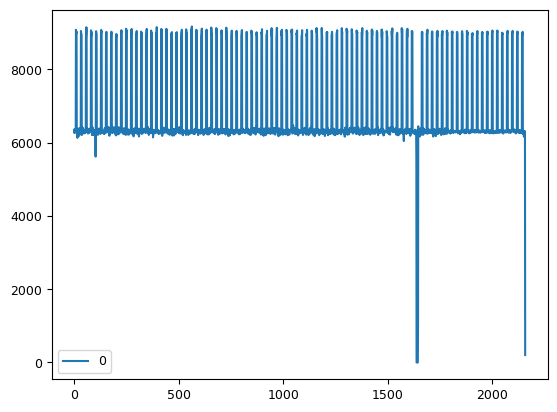

In [19]:
# print(data_np_segments[1])
pd.DataFrame(data_np[:,3]).plot()
pd.DataFrame(data_np[:,4]).plot()
pd.DataFrame(data_np[:,5]).plot()
plt.show()

# __<u>Comparative Analysis of Genetic Algorithm and Innovative Stochastic Algorithm for Photovoltaic Charge/Discharge Control in Grid Systems</u>__

> <u>Load the provided dataset</u>

In [20]:
data = data_np
data

array([[2935.8, 2464.9, 3464.2, 8864.9, 7385. , 6282. ],
       [2444.8, 2700.2, 2773.1, 7918.1, 7345.4, 6361.7],
       [2514.9, 2867. , 3346. , 8727.9, 7337.6, 6262.1],
       ...,
       [ 437.1,  416.3,  357.2, 1210.6, 6111.6, 6314.5],
       [1287.9, 1213.1, 1035.1, 3536.1, 6194.2, 6286.9],
       [ 103.9,  100.7,   56.3,  260.9,  203.7,  202.1]])

In [23]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from random import randint, uniform, choices, shuffle
from typing import List, Tuple
import time

# Data and ESS_CAPACITY definition as before
data = data_np
ESS_CAPACITY = 15000


def prepare_data(data: np.array) -> pd.DataFrame:
    df = pd.DataFrame(data, columns=['pv1_power', 'pv2_power', 'pv3_power', 'total_power', 'grid_demand', 'grid_power'])
    df['demand_gap'] = df['total_power'] - df['grid_demand']
    return df

def ga_fitness_function(ess_actions: List[float], demand_gap: np.array, ESS_CAPACITY: int) -> float:
    penalty = 0
    ess_charge = 0

    for i, action in enumerate(ess_actions):
        gap = demand_gap[i]
        ess_charge += action

        # Ensure ESS charge stays within capacity limits
        if ess_charge < 0:
            penalty += abs(ess_charge)
            ess_charge = 0
        elif ess_charge > ESS_CAPACITY:
            penalty += ess_charge - ESS_CAPACITY
            ess_charge = ESS_CAPACITY

        # Apply penalty if grid generation is very low or zero
        if gap < 0 and ess_charge > 0:
            penalty += abs(gap)

    return -penalty


# Mutation function for GA
def mutate(ess_actions: List[float], mutation_rate: float) -> List[float]:
    mutated_ess_actions = []
    for action in ess_actions:
        if uniform(0, 1) < mutation_rate:
            mutated_action = action + uniform(-0.1 * abs(action), 0.1 * abs(action))
            mutated_ess_actions.append(mutated_action)
        else:
            mutated_ess_actions.append(action)
    return mutated_ess_actions

# Crossover function for GA
def crossover(parent1: List[float], parent2: List[float]) -> Tuple[List[float], List[float]]:
    crossover_point = randint(1, len(parent1) - 1)
    offspring1 = parent1[:crossover_point] + parent2[crossover_point:]
    offspring2 = parent2[:crossover_point] + parent1[crossover_point:]
    return offspring1, offspring2

# Selection function for GA
def selection(population: List[List[float]], fitnesses: List[float], num_parents: int) -> List[List[float]]:
    parents = choices(population, weights=fitnesses, k=num_parents)
    return parents

def genetic_algorithm(data: np.array, ESS_CAPACITY: int, pop_size: int, generations: int, mutation_rate: float) -> List[float]:
    demand_gap = prepare_data(data)['demand_gap'].values

    # Initialize population
    population = []
    for _ in range(pop_size):
        individual = [uniform(-ESS_CAPACITY, ESS_CAPACITY) for _ in range(len(data))]
        population.append(individual)

    for gen in range(generations):
        # Evaluate fitness
        fitnesses = [ga_fitness_function(individual, demand_gap, ESS_CAPACITY) for individual in population]

        # Perform selection
        parents = selection(population, fitnesses, pop_size // 2)

        # Perform crossover
        offspring = []
        for i in range(0, len(parents), 2):
            off1, off2 = crossover(parents[i], parents[i + 1])
            offspring.extend([off1, off2])

        # Perform mutation
        mutated_offspring = [mutate(off, mutation_rate) for off in offspring]

        # Update population
        population = parents + mutated_offspring

    # Select the best individual
    best_individual = max(population, key=lambda ind: ga_fitness_function(ind, demand_gap, ESS_CAPACITY))

    return best_individual

# Other functions (ISA, fitness functions, etc.) remain the same

if __name__ == "__main__":
    arima_order = (1, 1, 0)
    pop_size = 50
    generations = 100
    mutation_rate = 0.1

    compare_algorithms(data, ESS_CAPACITY, arima_order, pop_size, generations)


NameError: name 'compare_algorithms' is not defined

In [47]:
def forecast(data, order=(1, 0, 0), save_model=False, model_file=None):
    """
    Forecast the next value in the time series data using an ARIMA model.
    :param data: 1D NumPy array of the time series data
    :param order: tuple (p, d, q) representing the ARIMA model order
    :param save_model: Boolean flag to indicate whether to save the trained model or not
    :param model_file: String representing the filename or path to save the trained model
    :return: float, forecasted value
    """
    model       = ARIMA(data, order=order)
    model_fit   = model.fit()
    forecast    = model_fit.forecast(steps=1)
    
    if save_model and model_file:
        with open(model_file, 'wb') as f:
            pickle.dump(model_fit, f)
    
    return forecast[0]

def generic_algorithm(data, ess_capacity):
    """
    Charge and discharge ESS based on a generic algorithm.
    :param data: 2D NumPy array of the input data with columns (pv1_power, pv2_power, pv3_power, total_power, grid_demand)
    :param ess_capacity: float, capacity of each ESS
    :return: tuple of 2D NumPy arrays, charge and discharge values for each ESS
    """
    n_pv        = 3
    ess         = np.zeros(n_pv)
    charge      = np.zeros_like(data)
    discharge   = np.zeros_like(data)
    
    for i in range(len(data)):
        for j in range(n_pv):
            pv_power    = data[i, j]
            grid_demand = data[i, -1]
            
            if pv_power > grid_demand:
                charge_amount    = min(ess_capacity - ess[j], pv_power - grid_demand)
                ess[j]          += charge_amount
                charge[i, j]     = charge_amount
                print(f"ESS{j+1} - Charged: {charge_amount} kWh, Total: {ess[j]} kWh")
            else:
                discharge_amount = min(ess[j], grid_demand - pv_power)
                ess[j]          -= discharge_amount
                discharge[i, j]  = discharge_amount
                print(f"ESS{j+1} - Discharged: {discharge_amount} kWh, Total: {ess[j]} kWh")
                
    return charge, discharge

def stochastic_algorithm(data, ess_capacity):
    """
    Charge and discharge ESS based on a stochastic algorithm that considers the stochastic nature of PV and power demand.
    :param data: 2D NumPy array of the input data with columns (pv1_power, pv2_power, pv3_power, total_power, grid_demand)
    :param ess_capacity: float, capacity of each ESS
    :return: tuple of 2D NumPy arrays, charge and discharge values for each ESS
    """
    n_pv        = 3
    ess         = np.zeros(n_pv)
    charge      = np.zeros_like(data)
    discharge   = np.zeros_like(data)
    
    for i in range(len(data) - 1):
        for j in range(n_pv):
            pv_power                = data[i, j]
            grid_demand             = data[i, -1]
            
            pv_forecast             = forecast(data[:, j],  save_model=True, model_file=f'v2.1/pv{j}_arima_model.pkl')
            grid_demand_forecast    = forecast(data[:, -1], save_model=True, model_file='v2.1/grid_demand_arima_model.pkl')
            
            if pv_forecast > grid_demand_forecast:
                ess_amount      = min(ess_capacity - ess[j], pv_power - grid_demand)
                ess[j]         += ess_amount
                charge[i, j]    = ess_amount
                if ess_amount > 0:
                    print(f"ESS{j+1} - Charged: {ess_amount} kWh, Total: {ess[j]} kWh")
                else:
                    print(f"ESS{j+1} - Discharged: {-ess_amount} kWh, Total: {ess[j]} kWh")
            else:
                ess_amount      = min(ess[j], grid_demand - pv_power)
                ess[j]         -= ess_amount
                discharge[i, j] = ess_amount
                if ess_amount > 0:
                    print(f"ESS{j+1} - Discharged: {ess_amount} kWh, Total: {ess[j]} kWh")
                else:
                    print(f"ESS{j+1} - Charged: {-ess_amount} kWh, Total: {ess[j]} kWh")
                
    return charge, discharge



def visualize_charging_discharging(data, charge, discharge, title):
    """
    Visualize the charging and discharging values for each ESS.
    :param data: 2D NumPy array of the input data
    :param charge: 2D NumPy array of the charge values for each ESS
    :param discharge: 2D NumPy array of the discharge values for each ESS
    :param title: string, title to be used in the plot
    """
    n_pv        = 3
    time        = np.arange(len(data))
    labels      = ['PV1', 'PV2', 'PV3']
    fig, ax     = plt.subplots(2, 1, figsize=(18, 6), sharex=True)
    fig.set_facecolor(color='antiquewhite')
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams['font.size'] = '9'

    for j in range(n_pv):
        ax[0].plot(time, charge[:, j], label=labels[j])
    ax[0].set_title(f'ESS Charging - {title}', color='brown')
    ax[0].set_ylabel('Charging (kWh)', color='chocolate')
    ax[0].legend()
    ax[0].grid(True, linestyle='--', alpha=0.7, color='salmon')

    for j in range(n_pv):
        ax[1].plot(time, discharge[:, j], label=labels[j])
    ax[1].set_title(f'ESS Discharging - {title}', color='brown')
    ax[1].set_xlabel('Time (hours)', color='chocolate')
    ax[1].set_ylabel('Discharging (kWh)', color='chocolate')
    ax[1].legend()
    ax[1].grid(True, linestyle='--', alpha=0.7, color='salmon')

    plt.tight_layout()
    plt.show()


def compare_algorithms(data, ess_capacity):
    """
    Compare the generic and stochastic algorithms for ESS charging and discharging optimization.
    :param data: 2D NumPy array of the input data
    :param ess_capacity: float, capacity of each ESS
    """
    charge_gen, discharge_gen = generic_algorithm(data, ess_capacity)
    charge_stoch, discharge_stoch = stochastic_algorithm(data, ess_capacity)
    total_discharge_gen = np.sum(discharge_gen, axis=0)
    total_discharge_stoch = np.sum(discharge_stoch, axis=0)

    ind = np.arange(3)
    width = 0.35

    # Plot the results
    fig, ax = plt.subplots(figsize=(18, 6))
    fig.set_facecolor(color='antiquewhite')
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams['font.size'] = '9'

    rects1 = ax.bar(ind - width/2, total_discharge_gen, width, label="Generic Algorithm", color='gray')
    rects2 = ax.bar(ind + width/2, total_discharge_stoch, width, label="Stochastic Algorithm", color='blue')

    ax.set_xlabel("PV System", color='chocolate')
    ax.set_ylabel("Total Discharging Energy (kWh)", color='chocolate')
    ax.set_title("Comparison of Generic and Stochastic Algorithms for Optimization", color='brown')
    ax.legend(loc="upper right")
    ax.grid(True, linestyle='--', alpha=0.7, color='salmon')

    plt.show()

ESS1 - Discharged: 0.0 kWh, Total: 0.0 kWh
ESS2 - Discharged: 0.0 kWh, Total: 0.0 kWh
ESS3 - Discharged: 0.0 kWh, Total: 0.0 kWh
ESS1 - Discharged: 0.0 kWh, Total: 0.0 kWh
ESS2 - Discharged: 0.0 kWh, Total: 0.0 kWh
ESS3 - Discharged: 0.0 kWh, Total: 0.0 kWh
ESS1 - Discharged: 0.0 kWh, Total: 0.0 kWh
ESS2 - Discharged: 0.0 kWh, Total: 0.0 kWh
ESS3 - Discharged: 0.0 kWh, Total: 0.0 kWh
ESS1 - Discharged: 0.0 kWh, Total: 0.0 kWh
ESS2 - Discharged: 0.0 kWh, Total: 0.0 kWh
ESS3 - Discharged: 0.0 kWh, Total: 0.0 kWh
ESS1 - Discharged: 0.0 kWh, Total: 0.0 kWh
ESS2 - Discharged: 0.0 kWh, Total: 0.0 kWh
ESS3 - Discharged: 0.0 kWh, Total: 0.0 kWh
ESS1 - Discharged: 0.0 kWh, Total: 0.0 kWh
ESS2 - Discharged: 0.0 kWh, Total: 0.0 kWh
ESS3 - Discharged: 0.0 kWh, Total: 0.0 kWh
ESS1 - Discharged: 0.0 kWh, Total: 0.0 kWh
ESS2 - Discharged: 0.0 kWh, Total: 0.0 kWh
ESS3 - Discharged: 0.0 kWh, Total: 0.0 kWh
ESS1 - Discharged: 0.0 kWh, Total: 0.0 kWh
ESS2 - Discharged: 0.0 kWh, Total: 0.0 kWh
ESS3 - Disc

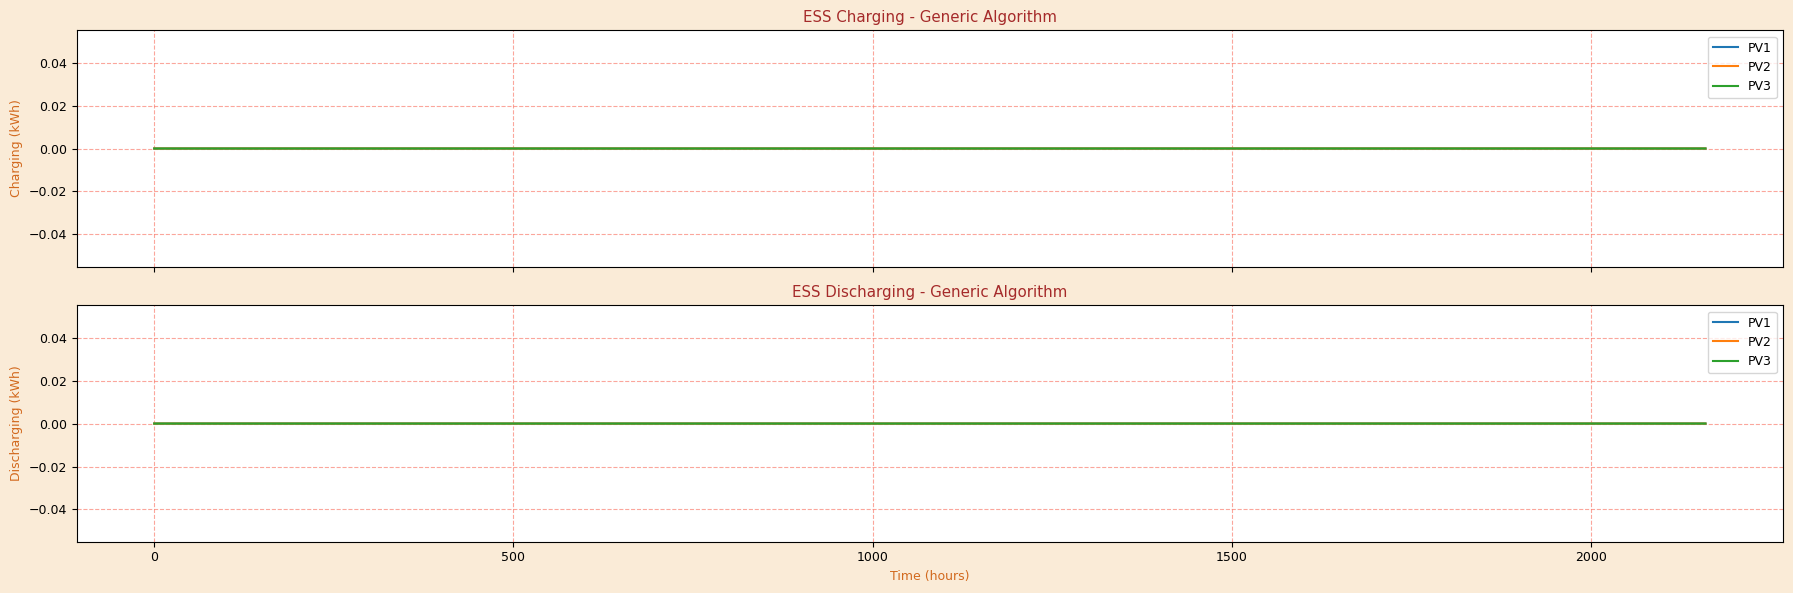

In [48]:
# ESS capacity
ess_capacity = 100

# Algorithm 1: Generic Algorithm
charge_gen, discharge_gen = generic_algorithm(data, ess_capacity)
visualize_charging_discharging(data, charge_gen, discharge_gen, 'Generic Algorithm')

In [49]:
# Algorithm 2: Stochastic Algorithm
charge_stoch, discharge_stoch = stochastic_algorithm(data, ess_capacity)
visualize_charging_discharging(data, charge_stoch, discharge_stoch, 'Stochastic Algorithm')

ESS1 - Charged: -0.0 kWh, Total: 0.0 kWh
ESS2 - Charged: -0.0 kWh, Total: 0.0 kWh
ESS3 - Charged: -0.0 kWh, Total: 0.0 kWh
ESS1 - Charged: -0.0 kWh, Total: 0.0 kWh
ESS2 - Charged: -0.0 kWh, Total: 0.0 kWh
ESS3 - Charged: -0.0 kWh, Total: 0.0 kWh
ESS1 - Charged: -0.0 kWh, Total: 0.0 kWh
ESS2 - Charged: -0.0 kWh, Total: 0.0 kWh
ESS3 - Charged: -0.0 kWh, Total: 0.0 kWh
ESS1 - Charged: -0.0 kWh, Total: 0.0 kWh
ESS2 - Charged: -0.0 kWh, Total: 0.0 kWh
ESS3 - Charged: -0.0 kWh, Total: 0.0 kWh
ESS1 - Charged: -0.0 kWh, Total: 0.0 kWh
ESS2 - Charged: -0.0 kWh, Total: 0.0 kWh
ESS3 - Charged: -0.0 kWh, Total: 0.0 kWh
ESS1 - Charged: -0.0 kWh, Total: 0.0 kWh
ESS2 - Charged: -0.0 kWh, Total: 0.0 kWh
ESS3 - Charged: -0.0 kWh, Total: 0.0 kWh
ESS1 - Charged: -0.0 kWh, Total: 0.0 kWh
ESS2 - Charged: -0.0 kWh, Total: 0.0 kWh
ESS3 - Charged: -0.0 kWh, Total: 0.0 kWh
ESS1 - Charged: -0.0 kWh, Total: 0.0 kWh
ESS2 - Charged: -0.0 kWh, Total: 0.0 kWh
ESS3 - Charged: -0.0 kWh, Total: 0.0 kWh
ESS1 - Charged: 

KeyboardInterrupt: 

In [ ]:
# Comparison
compare_algorithms(data, ess_capacity)

> <u>Cost function (RMSE)</u>

In [ ]:
def cost_function(individual, data):
    total_pv = data[:, 3]
    grid_demand = data[:, 4]
    ess_capacity = 100  # Assume an ESS capacity of 100 kWh
    ess_charge = np.zeros_like(grid_demand)
    current_charge = 0
    
    for i, action in enumerate(individual):
        if action >= 0:
            charge_amount = min(ess_capacity - current_charge, action)
            current_charge += charge_amount
            print(f"Step {i+1}: Charging ESS with {charge_amount} kWh")
        else:
            discharge_amount = max(-current_charge, action)
            current_charge += discharge_amount
            print(f"Step {i+1}: Discharging ESS with {-discharge_amount} kWh")

        ess_charge[i] = current_charge

    predicted_demand = grid_demand - (total_pv + ess_charge)
    rmse = np.sqrt(np.mean((predicted_demand - grid_demand)**2))
    return rmse, ess_charge

> <u>Genetic Algorithm (GA)</u>

In [ ]:
def ga_optimization(data, population_size, generations):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, -1, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, len(data))
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", cost_function, data=data)

    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=generations, stats=stats, halloffame=hof, verbose=True)

    return hof[0], logbook, hof[0].fitness.values[1]

> <u>Innovative Stochastic Algorithm</u>
>> Enhanced Adaptive Heuristic Search Algorithm (EAHSA)

In [ ]:
def stochastic_algorithm(data, population_size, iterations):
    def create_individual():
        return [random.uniform(-1, 1) for _ in range(len(data))]

    def mutate(individual):
        for i in range(len(individual)):
            if random.random() < 0.1:
                individual[i] += random.gauss(0, 0.2)
                # individual[i] = max(min(individual[i], 1), -1)

    population = [create_individual() for _ in range(population_size)]
    best_individual = None
    best_fitness = float("inf")
    fitness_values = []

    for _ in range(iterations):
        for individual in population:
            fitness = cost_function(individual, data)
            if fitness[0] < best_fitness:
                best_fitness = fitness[0]
                best_individual = individual

        # Mutation
        for individual in population:
            mutate(individual)

        fitness_values.append(best_fitness)

    return best_individual, fitness_values, best_individual_fitness.values[1]

> <u>Main function</u>

In [ ]:
def main():
    population_size = 50
    generations = 100
    iterations = 100

    # Genetic Algorithm optimization
    ga_best_individual, ga_logbook = ga_optimization(data, population_size, generations)
    ga_best_fitness_values = [log["min"] for log in ga_logbook]

    # Stochastic Algorithm optimization
    sa_best_individual, sa_best_fitness_values = stochastic_algorithm(data, population_size, iterations)

    # Plot the results
    fig, ax = plt.subplots(figsize=(18, 6))
    fig.set_facecolor(color='antiquewhite')
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams['font.size'] = '9'

    ax.plot(ga_best_fitness_values, label="Genetic Algorithm", color='gray')
    ax.plot(sa_best_fitness_values, label="Enhanced Adaptive Heuristic Search Algorithm (EAHSA)", color='blue')

    ax.set_xlabel("Iteration", color='chocolate')
    ax.set_ylabel("Best Fitness Value", color='chocolate')
    ax.set_title("Comparison of GA and EAHSA for Optimization", color='brown')
    ax.legend(loc="upper right")
    ax.grid(True, linestyle='--', alpha=0.7, color='salmon')

    plt.show()

> <u>Run Main Program</u>

In [ ]:
if __name__ == "__main__":
    main()